[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

#2. Generating Neighbourhood and Network Files

In [2]:
#@title Mount Google Drive

#Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
!rm -rf /content/sample_data

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


####Import modules

In [0]:
#Import modules
import os
import time
from datetime import datetime as dt
import scipy.stats as stats
import json
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import IPython
from IPython.display import display, HTML
from google.colab import widgets

####User input of variables

In [0]:
#@title Input form {display-mode: "form"}

#@markdown Enter the species name in the format "_**Genus_species**_", Eg: '_**Elaeis_guineensis**_'

#@markdown The folder name in your Google Drive main directory should also go by this name.

species_name = 'Elaeis_guineensis' #@param {type: 'string'}

#@markdown ---

#@markdown File name for Run Table (with extension), stored in Google Drive species folder.

#@markdown Eg: '_**RunTableTest.txt**_'

RunTable_file = 'RunTable_Elaeis_guineensis.txt' #@param {type: 'string'}

#@markdown ---

#@markdown File name for CDS file (with extension), stored in Google Drive species folder.

#@markdown Eg: '_**cds.selected_transcript.egu.fasta.gz**_'

cds_fasta_file = 'cds.selected_transcript.egu.fasta.gz' #@param {type: 'string'}

#@markdown ---

#@markdown Mercator file name containing the Mapman Bins of genes in the CDS

mercator_file_name = 'Mercator_Elaeis_guineensis.txt' #@param {type: 'string'}

#@markdown ---

#@markdown Guide Genes for generating neighbourhood

#@markdown Enter a maximum of 3 Guide Genes. Ensure that the Gene ID used is consistent with that of the CDS file.

#@markdown Eg: '_**EGU2621G0126.01**_'

guide_gene_1 = 'EGU2621G0126.01' #@param {type: 'string'}
guide_gene_1 = guide_gene_1.upper()
guide_gene_2 = 'EGU2621G1907.01' #@param {type: 'string'}
guide_gene_2 = guide_gene_2.upper()
guide_gene_3 = 'EGU2211G0996.01' #@param {type: 'string'}  
guide_gene_3 = guide_gene_3.upper()
list_of_guide_genes = [guide_gene_1, guide_gene_2, guide_gene_3]

#@markdown ---

#@markdown Enter the date on the download folder

Date_download_initiated = '2020-01-20' #@param {type: 'date'}
date = Date_download_initiated

####Initialise Variables

In [0]:
working_dir_path = "/content/gdrive/My Drive/" + species_name + "/"
working_dir_path_ter = "/content/gdrive/My\ Drive/" + species_name + "/"

files = os.listdir(working_dir_path)
filename = max([filename for filename in files if date in filename])
execution_dir_path = working_dir_path + filename + "/"
execution_dir_path_ter = working_dir_path_ter + filename + "/"
os.chdir(execution_dir_path)

RunTablePath = working_dir_path + RunTable_file
qc_file_path = execution_dir_path + "qc_file.txt"
tpm_table_file_name = "compiled_tpm_table_" + species_name + ".txt"

In [0]:
#Get ListOfRunID
with open(RunTablePath,"r") as RunTable:
  ListOfRunID = [RunID.strip().upper() for RunID in RunTable.readlines()]
if "RUNID" in ListOfRunID[0]: #If input file has header, exclude header
  ListOfRunID = ListOfRunID[1:]

##2.1 Quality control

####QC Codes

In [0]:
#Functions#############################################################

def count_genes_mapped(RunID):
  '''Reads the abundance.tsv file in the RunID directory and count the number of genes with TPM > 0 
  Specific for the experiment RunID.
  '''
  with open(execution_dir_path + RunID + "/abundance.tsv", "r") as kallisto_abundance_file:
    kallisto_abundance_file.readline()    #Read the header line
    kallisto_output = [line.strip().split('\t') for line in kallisto_abundance_file.readlines()]

  gene_count = 0
  for kallisto_row in kallisto_output:
    if float(kallisto_row[4]) != 0:
      gene_count += 1
  return gene_count

######################################################################

def make_qc_file(qc_file_path):
  '''
  Makes a QC file if it does not already exists
  '''
  qc_file = open(qc_file_path,"w+")
  qc_header = '\t'.join(['RunID', 'Reads pseudoaligned', 'Reads processed', '% Reads pseudoaligned', 'Gene count', 'Total targets', '% Genes mapped']) + '\n'
  qc_file.write(qc_header)

  for RunID in ListOfRunID:
    RunID_file_path = execution_dir_path + RunID + "/"
    
    if os.path.exists(RunID_file_path) == False:
      print(RunID + ": RunID directory not found.")
    
    else:
      if os.path.exists(RunID_file_path + "abundance.tsv") == False:
        print(RunID + ": abundance.tsv not found.")
        continue
      else:
        #Count genes which mapped to cds (i.e. tpm > 0)
        gene_count = count_genes_mapped(RunID)
      
      if os.path.exists(RunID_file_path + "run_info.json") == False:
        print(RunID + ": run_info.json not found.")
        continue
      else:
        with open(RunID_file_path + 'run_info.json', 'r') as run_info_file:
          run_info = json.load(run_info_file) #json.loads takes a string, json.load takes a json file, both returns a dict.
          targets = int(run_info['n_targets'])
          bootstraps = int(run_info['n_bootstraps'])
          processed = int(run_info['n_processed'])
          pseudoaligned = int(run_info['n_pseudoaligned'])
          unique = int(run_info['n_unique'])
          p_pseudoaligned = float(run_info['p_pseudoaligned'])
          p_unique = float(run_info['p_unique'])
        
        p_genes_mapped = round((gene_count/targets)*100, 1) #Genes with tpm != 0 / targets , in %

        qc_output = [RunID, pseudoaligned, processed, p_pseudoaligned, gene_count, targets, p_genes_mapped]
        to_write = '\t'.join([str(entry) for entry in qc_output]) + '\n'
        qc_file.write(to_write)

  qc_file.close()
  if os.path.exists(qc_file_path):
    print("qc_file created.")
  else:
    print("qc_file is not created.")

In [32]:
qc_file_path = execution_dir_path + "qc_file.txt"
if not os.path.exists(qc_file_path):
  make_qc_file(qc_file_path)
else:
  #Avoid recompiling, waste of time
  print("qc_file already exists.")

qc_file already exists.


In [0]:
#plot visualisation of log(n_processed) against % pseudoaligned

with open(qc_file_path, 'r') as qc_file:
  qc_file.readline() #header
  qc_list = [line.strip().split('\t') for line in qc_file.readlines()]

# Use JointGrid directly to draw a custom plot
RunIDs = [line[0] for line in qc_list]
pseudoaligned = [int(line[1]) for line in qc_list]
processed = [int(line[2]) for line in qc_list]
p_pseudoaligned = [float(line[3]) for line in qc_list] 

gene_count = [int(line[4]) for line in qc_list]
targets = [int(line[5]) for line in qc_list]
p_genes_mapped = [float(line[6]) for line in qc_list]

x = [p for p in p_pseudoaligned]
y = []
for line in qc_list: # to avoid nan from log10(0) error
  if int(line[2]) != 0:
    y.append(np.log10(int(line[2])))
  else:
    y.append(0)

qc_df = pd.DataFrame({'RunID': RunIDs, 'Reads Pseudoaligned':pseudoaligned, 'Reads Processed':processed, '% pseudoaligned': p_pseudoaligned, 'log10(Processed Reads)': y,\
                      'Gene count': gene_count, 'Total targets': targets, '% genes mapped': p_genes_mapped})

####QC Inspection and Visualisation

In [34]:
#@title Quality Control Table

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500})'''))

tab = widgets.TabBar(["Sorted by reads processed", "Sorted by % pseudoaligned", "Sorted by % genes_mapped"], location = "bottom")
columns = ["Reads Processed", "% pseudoaligned", "% genes mapped"]
for sort_column in columns:
  new_qc_df = qc_df.sort_values(by=[sort_column], inplace=False, ascending=False)
  with tab.output_to(columns.index(sort_column), select=False):
    pd.set_option('display.max_rows', 200)
    display(HTML(new_qc_df.to_html()))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,RunID,Reads Pseudoaligned,Reads Processed,% pseudoaligned,log10(Processed Reads),Gene count,Total targets,% genes mapped
127,SRR3042540,0,27989076,0.0,7.446989,25487,25487,100.0
125,SRR3042536,5,27187203,0.0,7.434365,3,25487,0.0
126,SRR3042537,10,26769804,0.0,7.427645,10,25487,0.0
119,SRR5189965,75,24387647,0.0,7.387170,38,25487,0.1
60,SRR8432494,506190,20670705,2.4,7.315355,17801,25487,69.8
83,SRR7263083,1554844,20171612,7.7,7.304741,16894,25487,66.3
59,SRR8432495,382996,19410578,2.0,7.288038,17078,25487,67.0
94,SRR7263094,3752114,18525924,20.3,7.267780,19927,25487,78.2
118,SRR5189964,6,18457329,0.0,7.266169,4,25487,0.0
96,SRR7263096,5566284,17429634,31.9,7.241288,19633,25487,77.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,RunID,Reads Pseudoaligned,Reads Processed,% pseudoaligned,log10(Processed Reads),Gene count,Total targets,% genes mapped
219,SRR654050,8641566,13009193,66.4,7.114250,478,25487,1.9
108,SRR7812013,8320382,12628812,65.9,7.101362,22739,25487,89.2
109,SRR7812014,8220157,12627816,65.1,7.101328,22945,25487,90.0
31,SRR9102728,7719461,11873403,65.0,7.074575,21937,25487,86.1
110,SRR7812015,8005864,12339872,64.9,7.091311,21921,25487,86.0
218,SRR1259332,7593518,11857705,64.0,7.074001,22209,25487,87.1
111,SRR7812016,8109416,12749637,63.6,7.105498,22039,25487,86.5
44,SRR9102741,7532503,11900563,63.3,7.075568,22019,25487,86.4
48,SRR9102745,7478236,11885099,62.9,7.075003,21928,25487,86.0
54,SRR9102751,7468511,11906653,62.7,7.075790,22244,25487,87.3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,RunID,Reads Pseudoaligned,Reads Processed,% pseudoaligned,log10(Processed Reads),Gene count,Total targets,% genes mapped
180,SRR1999829,0,668,0.0,2.824776,25487,25487,100.0
204,SRR1999876,0,592,0.0,2.772322,25487,25487,100.0
176,SRR1999821,0,240,0.0,2.380211,25487,25487,100.0
177,SRR1999824,0,175,0.0,2.243038,25487,25487,100.0
178,SRR1999826,0,240,0.0,2.380211,25487,25487,100.0
179,SRR1999827,0,156,0.0,2.193125,25487,25487,100.0
147,SRR1999741,0,188,0.0,2.274158,25487,25487,100.0
181,SRR1999833,0,1689,0.0,3.227630,25487,25487,100.0
182,SRR1999834,0,123,0.0,2.089905,25487,25487,100.0
183,SRR1999836,0,72,0.0,1.857332,25487,25487,100.0


<IPython.core.display.Javascript object>

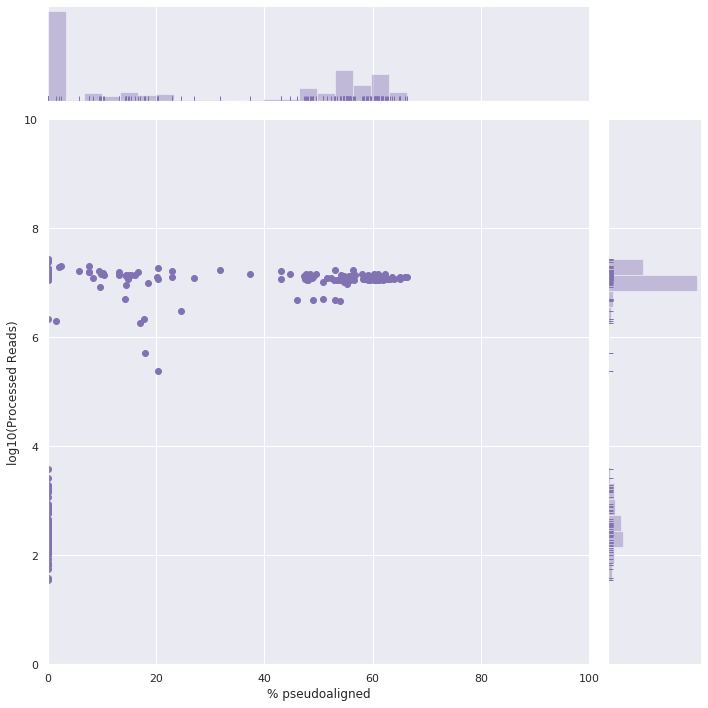

In [35]:
#@title Scatter plot of log10( number of processed reads ) against % of targets pseudoaligned in each experiment


sns.set(style="darkgrid")

qc_df = pd.DataFrame({'% pseudoaligned': x, 'log10(Processed Reads)': y})
g = sns.jointplot('% pseudoaligned', 'log10(Processed Reads)', data = qc_df, kind="scatter",
                  xlim=(0, 100), ylim=(0, 10), color="m", height=10, marginal_kws=dict(bins=20, rug=True))

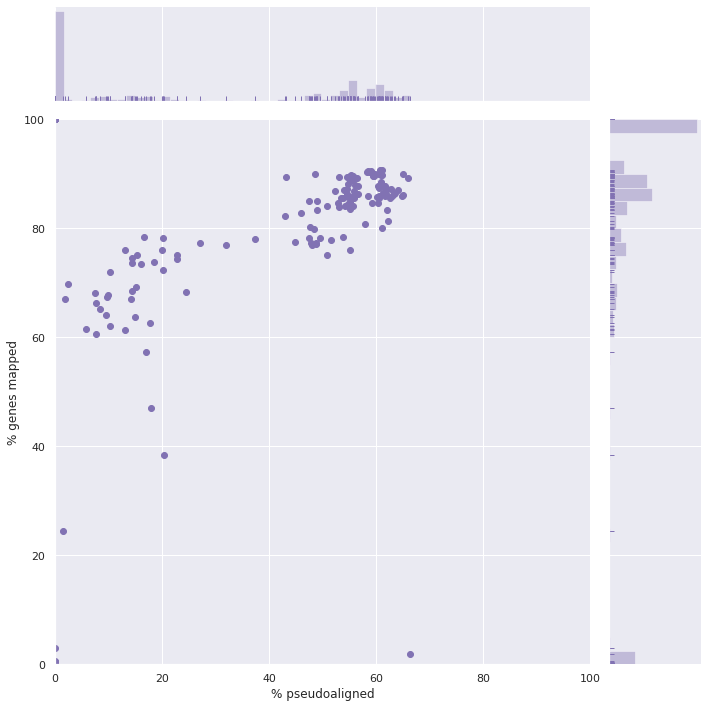

In [36]:
#@title Scatter plot of % of genes mapped against % of targets pseudoaligned in each experiment

sns.set(style="darkgrid")

qc_df = pd.DataFrame({'% pseudoaligned': x, '% genes mapped': p_genes_mapped})
g = sns.jointplot('% pseudoaligned', '% genes mapped', data = qc_df, kind="scatter",
                  xlim=(0, 100), ylim=(0, 100), color="m", height=10, marginal_kws=dict(bins=40, rug=True))

In [37]:
#@title Determine Quality Control Cutoff {display-mode: "form", run: "auto"}
#@markdown Assess the qc_file output. Then arbitarily decide on the treshold values. Only RunIDs with threshold above these will be used for analysis. 

p_pseudoaligned_threshold = 40  #@param {type: "slider", min: 0, max: 100}

#@markdown Enter the log<sub>10</sub> of reads processed instead of absolute number.
reads_processed_threshold = 6 #@param {type: "slider", min: 0, max: 10, step: 0.1}

p_genes_mapped_threshold = 60 #@param {type: "slider", min: 0, max: 100}

#title Collect RunIDs above threshold

with open(qc_file_path,"r") as qc_file:
  qc_file.readline()
  entries = qc_file.readlines()

accepted_RunIDs = []

for entry in entries:
  RunID = entry.strip().split('\t')[0]
  ra = float(entry.strip().split('\t')[3]) #% reads pseudoaligned
  rp = float(entry.strip().split("\t")[2]) #reads processed
  gm = float(entry.strip().split('\t')[6]) #% genes mapped

  if ra >= p_pseudoaligned_threshold and rp >= reads_processed_threshold and gm >= p_genes_mapped_threshold:
    accepted_RunIDs.append(RunID)

print("Number of accepted Run IDs:"+ str(len(accepted_RunIDs)) + "/" + str(len(ListOfRunID)))

to_recompile_tpm_values = False #@param {type:"boolean"}

Number of accepted Run IDs:99/220


###2.2 Data Extraction

####Compile TPM values

In [0]:
#Functions#############################################################

def compile_tpm(accepted_RunIDs, tpm_table_file_name):
  #Iterate through the list of selected RunIDs
  for RunID in accepted_RunIDs:
    RunID_file_path = execution_dir_path + RunID + "/"
    if os.path.exists(RunID_file_path) == False:
      print(RunID + ": RunID directory not found.")
    else:
      #Read abundance.tsv file
      kallisto_abundance_file = open(RunID_file_path + "abundance.tsv", "r")
      kallisto_abundance_file.readline()    #Read the header line
      kallisto_output = kallisto_abundance_file.readlines()
      kallisto_abundance_file.close()

    #Extract TPM values
    if RunID == accepted_RunIDs[0]:
      #Create a dictionary where the genes in the kallisto index file serve as the key and the value is an empty dictionary each.
      dict_of_genes = {(line.strip().split('\t')[0]):{} for line in kallisto_output}
    
    #Update dict_of_genes with tpm values of the current RunID
    #Store TPM values under the corresponding gene keys
    #The value stored to each gene key is a nested dictionary of TPM values mapped to RunID as keys
    #dict_of_genes = {Genes:{RunID:TPM}}
    for line in kallisto_output:
      row_list = line.strip().split('\t')
      dict_of_genes[row_list[0]][RunID] = row_list[4]

  #Record TPM values into compiled table
  compiled_tpm_table = open(execution_dir_path + tpm_table_file_name, "w+")

  #First row header of all the Runs
  header = "Genes"
  for RunID in accepted_RunIDs:
      header += ("\t" + RunID)
  header += "\n"
  compiled_tpm_table.write(header)

  #Fill up row by row by genes
  #dict_of_genes = {Genes:{RunID:TPM}}
  for gene in dict_of_genes:
      line = gene + "\t"
      for RunID in accepted_RunIDs:
          if RunID in dict_of_genes[gene].keys():
              line += (dict_of_genes[gene][RunID] + "\t")
          else:
              line += "nan\t"
              print("Missing TPM value for " + gene + ", " + RunID)
      
      #Replace last \t with \n
      line = line[:-1]
      line += "\n"
      #Write the row to the txt file
      compiled_tpm_table.write(line)
  compiled_tpm_table.close()
  print("TPM Table created.")

  return dict_of_genes

######################################################################

In [39]:
tpm_table_file_name = "compiled_tpm_table_" + species_name + ".txt"
if (not os.path.exists(tpm_table_file_name)) or to_recompile_tpm_values == True:
  dict_of_genes = compile_tpm(accepted_RunIDs, tpm_table_file_name)
else:
  print("TPM table already present.")

TPM table already present.


####Set cutoff

In [0]:
#@title PCC Cutoff & Neighbourhood size {display-mode: "form", run: "auto"}

cutoff = 0.70  #@param {type:"slider", min:0, max:1, step:0.01}
neighbourhood_size = 51 #@param {type: "slider", min:1, max:201, step:1}

to_recompile_files = False #@param {type:"boolean"}

####Generate PCC between pairs of genes
Ouputs for each guide gene:
- Neighbourhood file
- Network file

In [0]:
#Functions#############################################################

def extract_mercator(mercator_file_path):
  #Stores gene description
  with open(mercator_file_path, 'r') as mercator_file:
    mercator_file.readline() #header
    mercator_lines = mercator_file.readlines()

  description_dict = {}

  for line in mercator_lines:
    line_list = line.strip().split('\t')
    geneID = line_list[2].strip('\'').upper()
    bin_code = line_list[0].strip('\'')
    bin_name = line_list[1].strip('\'')
    gene_description = line_list[3].strip('\'')
    if geneID != '':
      description_dict[geneID] = [bin_code, bin_name, gene_description]

  return description_dict

######################################################################

def read_tpm_table(tpm_table_file_path):
  #Read TPM Table
  compiled_tpm_table = open(tpm_table_file_path, "r")
  #Read header and store RunIDs, use index of RunID to identify. 
  RunID_list = compiled_tpm_table.readline().strip().split()[1:]

  #Read each row for each gene
  #[genes, ...]
  #[[tpm of gene 1], [tpm of gene 2], ...]
  genes_tpm_rows = compiled_tpm_table.readlines() #list of rows
  genes_list = [line.strip().split('\t')[0] for line in genes_tpm_rows]
  tpm_list_of_lists = [line.strip().split('\t')[1:] for line in genes_tpm_rows]
  compiled_tpm_table.close()

  return RunID_list, genes_list, tpm_list_of_lists

######################################################################

def verify_guide_genes(list_of_guide_genes, genes_list):
  #Check if guide genes inserted in input section is a GeneID present in genes_list
  for guide_gene in list_of_guide_genes:
    if guide_gene not in genes_list:
      print("The gene " + guide_gene + " is invalid.")
      list_of_guide_genes.remove(guide_gene)
  
  return list_of_guide_genes

######################################################################

def get_neighbourhood_file(GoI, neighbourhood_file_path, genes_list, tpm_list_of_list, description_dict):
  #1 Create neightbourhood file output for this guide gene
  neighbourhood_file = open(neighbourhood_file_path, 'w+')
  neighbourhood_file.write('Neighbourhood file for ' + GoI + '\n')
  neighbourhood_file.write('Gene ID\tPCC Value\tp-value\tMapman Bin Code\tMapman Bin Name\tDescription\n')

  GoI_index = genes_list.index(GoI)
  tpm_GoI = [float(tpm) for tpm in tpm_list_of_lists[GoI_index]]

  #Generate a list of list [[gene ID, PCC, p-value], [], ...]
  PCC_output = []

  #Pair GoI with every other gene in genes_list
  for i in range(len(genes_list)):
    tpm_gene2 = [float(tpm) for tpm in tpm_list_of_lists[i]]
    PCC_value, p_value = stats.pearsonr(tpm_GoI, tpm_gene2)
    if PCC_value > cutoff: #Only append pairs with PCC > cutoff
      PCC_output.append([genes_list[i], PCC_value, p_value])

  #Sort by PCC
  PCC_sorted = sorted(PCC_output, key = lambda x: x[1], reverse = True)
  PCC_top = PCC_sorted[:neighbourhood_size] #Write only the top PCC by neighbourhood size

  #Add gene description
  #description_dict = {geneID: [bin_code, gene_name, gene_description]}
  PCC_top_annotated = []
  for result in PCC_top:
    geneID = result[0]
    result.extend(description_dict[geneID]) #extend with [bin_code, bin name, genedesc]
    PCC_top_annotated.append(result) #[gene ID, PCC, p-value, bin_code, bin name, genedesc]

  #write to neighbourhood file
  for result in PCC_top_annotated: 
    result = [str(e) for e in result]
    to_write = '\t'.join(result) + '\n' 
    neighbourhood_file.write(to_write)

  neighbourhood_file.close()

  print(GoI + ": neighbourhood file created.")

######################################################################

def create_network(GoI, neighbourhood_file_path, network_file_path, genes_list, tpm_list_of_lists):
  #Read neightbourhood file output
  with open(neighbourhood_file_path, 'r') as neighbourhood_file:
    neighbourhood_file.readline() #Title
    neighbourhood_file.readline() #Headers
    neighbourhood_lines = neighbourhood_file.readlines()

  #Collect top genes including GoI itself
  network_genes = [line.strip().split('\t')[0] for line in neighbourhood_lines]

  #Create network file output
  network_file = open(network_file_path, 'w+')
  network_file.write('Network file for ' + GoI + '\n')
  network_file.write('Gene ID 1\tGene ID 2\tPCC Value\tp-value\n')

  #Iterate every gene
  for gene1 in network_genes:
    network_genes_index = network_genes.index(gene1) #for iterating through only genes in neighbourhood file
    genes_list_index1 = genes_list.index(gene1) #find index of gene in genes_list from container extracted by read_tpm_table function
    #Pair gene with every other gene below it in the list
    for i in range((network_genes_index + 1), len(network_genes)): #gene2 is iterated through all the genes below gene1 
      gene2 = network_genes[i]
      tpm_gene1 = [float(Exp) for Exp in tpm_list_of_lists[genes_list_index1]]
      genes_list_index2 = genes_list.index(gene2)
      tpm_gene2 = [float(Exp) for Exp in tpm_list_of_lists[genes_list_index2]]
      PCC_value, p_value = stats.pearsonr(tpm_gene1, tpm_gene2)

      if math.isnan(PCC_value):
        PCC_value, p_value = 0, 0

      if cutoff <= PCC_value <= 1.0:
        to_write = gene1 + '\t' + gene2 + '\t' + str(PCC_value) + '\t' + str(p_value) + '\n' 
        network_file.write(to_write)

  network_file.close()
  print(GoI + ": network file created.")

######################################################################

In [42]:
# Extract Mercator Description
description_dict = extract_mercator(working_dir_path + mercator_file_name)

# Read TPM table 
tpm_table_file_path = execution_dir_path + tpm_table_file_name 
RunID_list, genes_list, tpm_list_of_lists = read_tpm_table(tpm_table_file_path) 

# Get guide genes
list_of_guide_genes = verify_guide_genes(list_of_guide_genes, genes_list)

for guide_gene in list_of_guide_genes:
  #1 Create neighbourhood file
  neighbourhood_file_path = execution_dir_path + 'Neighbourhood_' + guide_gene + '.txt'
  if (not os.path.exists(neighbourhood_file_path)) or to_recompile_files == True:
    get_neighbourhood_file(guide_gene, neighbourhood_file_path, genes_list, tpm_list_of_lists, description_dict)
  else:
    print(guide_gene + ": neighbourhood file already present.")
  
  #2 Create network file
  network_file_path = execution_dir_path + 'Network_' + guide_gene + '.txt'
  if (not os.path.exists(network_file_path)) or to_recompile_files == True:
    create_network(guide_gene, neighbourhood_file_path, network_file_path, genes_list, tpm_list_of_lists) #Requires neighbourhood file to be created first
  else:
    print(guide_gene + ": network file already present.")

EGU2621G0126.01: neighbourhood file already present.
EGU2621G0126.01: network file already present.
EGU2621G1907.01: neighbourhood file already present.
EGU2621G1907.01: network file already present.
EGU2211G0996.01: neighbourhood file already present.
EGU2211G0996.01: network file already present.


##3. Visualisation of Co-expression Networks

####Function to generate network html files

---



In [0]:
#Functions#############################################################

def extract_nodes_and_edges(network_file_path):
  '''Opens a network file and return a list of all the edges and nodes within the network'''
  with open(network_file_path, 'r') as network_file:
    network_file.readline() #title
    network_file.readline() #header
    entries = [lines.strip().split('\t') for lines in network_file.readlines()]

  list_of_edges = []
  for i in range(len(entries)):
    if float(entries[i][2]) >= 0.7:
      edge = (entries[i][0], entries[i][1])
      list_of_edges.append(edge)

  list_of_nodes = []
  for j in list_of_edges:
    if j[0] not in list_of_nodes:
      list_of_nodes.append(j[0])
    if j[1] not in list_of_nodes:
      list_of_nodes.append(j[1])
  
  return list_of_nodes, list_of_edges

######################################################################

def generate_html_index(list_of_nodes, list_of_edges):
  '''Returns a string of a html with javascript code to render the network from list_of_nodes and list_of_edges'''
  front_html = '''\
  <!doctype html>
  <html>
    <head>
        <title>Network on Cytoscape</title>
        <script src='https://cdnjs.cloudflare.com/ajax/libs/cytoscape/3.9.4/cytoscape.min.js'></script>
    </head>

    <style>
        #cy {
            width: 1000px;
            height: 950px;
            }
    </style>

    <body style="background-color:rgb(194, 229, 243);">
      <div><p><a id="pngimage" href="#" download="NetworkImage.png">Click to Download as Image</a></p></div>
      <div id="cy"></div>
      <script>
        var cy = cytoscape({
          container: document.getElementById('cy'),
  '''


  mid_html = '''\
          elements: [\n'''

  #get nodes
  # { data: { id: 'a' } },
  for j in list_of_nodes:
    new_node = "\t"*5 + "{data: {id:\'" + j + "\'}},\n"
    mid_html += new_node

  #get edges
  for i in range(len(list_of_edges)):
    ID = list_of_edges[i][0] + " | " + list_of_edges[i][1]
    source = list_of_edges[i][0]
    target = list_of_edges[i][1]
    new_edge = "\t"*5 + "{\n" + "\t"*6 + "data: {\n" +\
      "\t"*6 + "id: \'" + ID + "\',\n" +\
      "\t"*6 + "source: \'" + source + "\',\n" +\
      "\t"*6 + "target: \'" + target + "\'\n" + "\t"*6 + "}\n" + "\t"*5 + "}"
    if i != (len(list_of_edges)-1):
      new_edge += ",\n"
    else:
      new_edge = new_edge + "],\n"
    mid_html += new_edge

  back_html = '''\
            style: [
              { 
              selector: 'node',
              style: {
                  shape: 'circle',
                  'height': '3px',
                  'width': '3px',
                  'background-color': 'white',
                  label: 'data(id)',
                  'border-style':'solid',
                  'border-color':'black',
                  'border-width':'0.1px',
                  'font-size': 1.2,
                  'text-margin-y':'-0.4px',
                  'text-outline-color':'white',
                  'text-outline-width':'0.15px',
                  'text-outline-opacity':0.8
                  }
              },
              {
              selector: 'edge',
              style: {
                  'width': '0.1px',
                  'line-style':'solid',
                  'line-fill':'solid',
                  'background-color': '#F5F5F5',
                  'opacity':0.4
                  }
              },
              {
              selector:'core',
              style: {
                  'outside-texture-bg-color':'white',
                  'outside-texture-bg-opacity':1
                  }
              },
MORE_STYLES
              ],
            layout: {
              name: 'cose',
              animateThreshold: 1,
              nodeOverlap: 100,
              gravity: 400,
              componentSpacing: 100,
              edgeElasticity: 100,
              minTemp: 1,
              initialTemp: 1000,
              stop: function() {
                  //generate PNG image to display from "id = pngimage"
                  var png64 = cy.png({bg:'white'});
                  document.getElementById('pngimage').setAttribute('href', png64);
                  }
              }
          });
      </script>
    </body>
  </html>
  '''

  index_html = front_html + mid_html + back_html
  return index_html

######################################################################

def save_index_file(index_html, guide_gene):
  '''Writes the html/js string into a html file and return the path to the new html file'''
  network_html_path = execution_dir_path + "Network_index_" + guide_gene + '.html'
  with open(network_html_path, 'w+') as index_file:
    index_file.write(index_html)
  return network_html_path

######################################################################

def style_one_node(GeneID, shape, color):
  '''Returns the string of html css style sheet to be added to the index html file'''
  node_styling='''\
              {
              selector: 'node[id="GENEID"]',
              style: {
                  shape: 'ENTER_SHAPE',
                  'background-color': 'ENTER_COLOR',
                  }
              },
'''
  node_styling = node_styling.replace('GENEID', GeneID)
  node_styling = node_styling.replace('ENTER_SHAPE', shape)
  node_styling = node_styling.replace('ENTER_COLOR', color)

  return node_styling

######################################################################

def read_neighbourhood_file(neighbourhood_file_path):
  with open(neighbourhood_file_path, "r") as neighbourhood_file:
    neighbourhood_file.readline() #title
    neighbourhood_file.readline() #header
    lines_list = [line.strip().split("\t") for line in neighbourhood_file.readlines()]

  # gene_info_dict = {GeneId : [bin_code, bin_fullname, description, ##arabiposis ortholog?##]}
  gene_info_dict = {}
  for line in lines_list:
    gene_info_dict[line[0]] = [line[3], line[4], line[5]]
  
  return gene_info_dict

######################################################################

def read_color_table(MapmanBin_color_table_path):
  '''Returns color_dict = {Bin number: [Bin name, shape, color]}'''
  with open(MapmanBin_color_table_path, "r") as color_table:
    color_table.readline() #header
    lines = [line.strip().split("\t") for line in color_table.readlines()]
  
  color_dict = {}
  for line in lines:
    color_dict[int(line[0])] = [line[1], line[2], line[3]]
  
  return color_dict

Calling the functions to create the network html files

In [0]:
# execution_dir_path = '/content/gdrive/My Drive/Elaeis_guineensis/2020-01-08_03/' #delete after
network_files = [file for file in os.listdir(execution_dir_path) if ('Network' in file and 'html' not in file)]
neighbourhood_files = [file for file in os.listdir(execution_dir_path) if ('Neighbourhood' in file and 'html' not in file)]

list_of_network_html_path = []
for guide_gene in list_of_guide_genes:
  #Read network file for nodes and edges
  list_of_nodes, list_of_edges = extract_nodes_and_edges(execution_dir_path + "Network_" + guide_gene + ".txt")
  index_html = generate_html_index(list_of_nodes, list_of_edges) #string
  index_html = index_html.replace('NetworkImage', guide_gene) #Specify Name of png file to be downloaded based on guide gene
  
  #Read neighbourhood files
  neighbourhood_file_path = execution_dir_path + 'Neighbourhood_' + guide_gene + '.txt'
  gene_info_dict = read_neighbourhood_file(neighbourhood_file_path) #Need to include arabidopsis orthologs too! (run diamond?)

  #Read Mapman Bin to Color table
  MapmanBin_color_table_path = "/content/gdrive/My Drive/Elaeis_guineensis/MapmanBin_colors.txt" #To specify earlier??
  color_dict = read_color_table(MapmanBin_color_table_path)

  all_node_styling = ""
  #Style every node from list_of_nodes[1:] based on bin codes
  for node in list_of_nodes[1:]:
    #get bin code
    bin_code = int(gene_info_dict[node][0].split(".")[0])
    shape, color = color_dict[bin_code][1], color_dict[bin_code][2]
    node_styling = style_one_node(node, shape, color)
    all_node_styling += node_styling

  #Style the guide gene (First in neighbourhood file) as gold star
  guide_gene_style = style_one_node(list_of_nodes[0], "star", "Gold")
  all_node_styling += guide_gene_style

  #replace 
  index_html = index_html.replace('MORE_STYLES', all_node_styling)

  # Save string into final html file
  network_html_path = save_index_file(index_html, guide_gene)
  list_of_network_html_path.append(network_html_path)

####Rendering the networks

In [45]:
#@title Legend for nodes based on Mapman Bins:

#color_dict = {Bin number: [Bin name, shape, color]}
color_dict = read_color_table(MapmanBin_color_table_path)

nodes_elements = ""
nodes_style = ""

for key in color_dict:
  bin_name, shape, color = color_dict[key][0], color_dict[key][1], color_dict[key][2]
  #Add node to elements
  new_node = "\t"*5 + "{data: {id:\'" + bin_name + "\'}},\n"
  nodes_elements += new_node
  #Add shape and color to node
  nodes_style += style_one_node(bin_name, shape, color)

legend_html_head = '''\
  <!doctype html>
  <html>
    <head>
        <title>Network on Cytoscape</title>
        <script src='https://cdnjs.cloudflare.com/ajax/libs/cytoscape/3.9.4/cytoscape.min.js'></script>
    </head>

    <style>
        #cy {
            width: 900px;
            height: 950px;
            }
    </style>
    
    <body>
      <div id="cy"></div>
      <script>
        var cy = cytoscape({
          container: document.getElementById('cy'),
            elements: [
				          // nodes
'''

legend_html_mid ='''
			      ],
            style: [
              {
              // Set the default node styling first
              selector: 'node',
              style: {
                  shape: 'circle',
                  'height': '20px',
                  'width': '20px',
                  'background-color': 'white',
                  'background-opacity':1,
                  label: 'data(id)',
                  'border-style':'solid',
                  'border-color':'black',
                  'border-width':'0.1px',
                  'font-size': 12,
                  'text-margin-y':'-20px',
                  'text-outline-color':'white',
                  'text-outline-width':'0.15px',
                  'text-outline-opacity':0.8
                  }
              },
              // Modify the node styling individually
'''

legend_html_tail ='''
              // Edge styling
              {
              selector: 'edge',
              style: {
                  'width': '0.1px',
                  'line-style':'solid',
                  'line-fill':'solid',
                  'background-color': '#F5F5F5',
                  'opacity':0.4
                  }
              },
              {
              selector:'core',
              style: {
                  'outside-texture-bg-color':'white',
                  'outside-texture-bg-opacity':1
                  }
              }
              ],
            layout: {
              name: 'grid',
              }
          });
          cy.zoomingEnabled(false);
      </script>
    </body>
  </html>
'''

legend_html = legend_html_head + nodes_elements.rstrip(",\n") + legend_html_mid + nodes_style + legend_html_tail
display(HTML(legend_html))

In [46]:
#@title Show First Network
network_html_path = list_of_network_html_path[0]
IPython.display.HTML(filename = network_html_path)

In [47]:
#@title Gene Query - First network { run: "auto" }

GeneID = "EGU2621G0126.01" #@param {type:"string"}

k = 0 #Guide Gene index
neighbourhood_file_path = execution_dir_path + 'Neighbourhood_' + list_of_guide_genes[k] + '.txt'
gene_info_dict = read_neighbourhood_file(neighbourhood_file_path) 
# gene_info_dict = {GeneId : [bin_code, bin_fullname, description, ##arabiposis ortholog?##]}

if GeneID in gene_info_dict.keys():
  info = gene_info_dict[GeneID]
  print("GeneID: " + GeneID)
  print("Mapman Bin Code: " + info[0])
  print("Mapman Bin Name: " + info[1])
  print("Dsecription: " + info[2])

else:
  print("Invalid GeneID")

GeneID: EGU2621G0126.01
Mapman Bin Code: 15.5.7.3
Mapman Bin Name: RNA biosynthesis.transcriptional regulation.AP2/ERF  transcription factor superfamily.transcription factor (AP2)
Dsecription: transcription factor (AP2) (original description: | EGU2621G0126)


In [48]:
#@title Details of Genes in First Network
neighbourhood_file_path = neighbourhood_files[0]
df = pd.read_table(neighbourhood_file_path, sep="\t", header=1)
pd.set_option('display.max_colwidth', -1)
df[["Gene ID", "PCC Value", "Mapman Bin Code", "Mapman Bin Name", "Description"]]

,Gene ID,PCC Value,Mapman Bin Code,Mapman Bin Name,Description
0,EGU2621G0126.01,1.000000,15.5.7.3,RNA biosynthesis.transcriptional regulation.AP2/ERF transcription factor superfamily.transcription factor (AP2),transcription factor (AP2) (original description: | EGU2621G0126)
1,EGU2441G0917.01,0.988738,5.1.2.2.1.2,Lipid metabolism.fatty acid biosynthesis.acetyl-CoA generation.plastidial pyruvate dehydrogenase complex.E1 pyruvate dehydrogenase subcomplex.subunit beta,subunit beta of E1 pyruvate dehydrogenase component (original description: | EGU2441G0917)
2,EGU1136G1181.01,0.986248,5.1.3.2.4,Lipid metabolism.fatty acid biosynthesis.acetyl-CoA carboxylation.polymeric acetyl-CoA carboxylase complex.biotin carboxylase subunit,biotin carboxylase subunit of polymeric acetyl-CoA carboxylase complex (original description: | EGU1136G1181)
3,EGU2028G0362.01,0.980310,5.1.4.1,Lipid metabolism.fatty acid biosynthesis.plastidial fatty acid synthase (ptFAS) system.acyl carrier protein (ptACP),acyl carrier protein (ptACP) (original description: | EGU2028G0362)
4,EGU1634G0648.01,0.974380,5.1.4.3,Lipid metabolism.fatty acid biosynthesis.plastidial fatty acid synthase (ptFAS) system.hydroxyacyl-ACP dehydratase (ptHD),hydroxyacyl-ACP dehydratase (ptHD) (original description: | EGU1634G0648)
5,EGU1634G0047.01,0.973281,5.1.2.2.2,Lipid metabolism.fatty acid biosynthesis.acetyl-CoA generation.plastidial pyruvate dehydrogenase complex.dihydrolipoamide acetyltransferase component E2,dihydrolipoamide acetyltransferase component E2 of plastidial pyruvate dehydrogenase complex (original description: | EGU1634G0047)
6,EGU0881G1273.01,0.973014,5.1.4.5,Lipid metabolism.fatty acid biosynthesis.plastidial fatty acid synthase (ptFAS) system.enoyl-ACP reductase (MOD1),enoyl-ACP reductase (original description: | EGU0881G1273)
7,EGU2755G0324.01,0.964613,5.1.3.2.3,Lipid metabolism.fatty acid biosynthesis.acetyl-CoA carboxylation.polymeric acetyl-CoA carboxylase complex.biotin carboxyl carrier subunit,biotin carboxyl carrier subunit of polymeric acetyl-CoA carboxylase complex (original description: | EGU2755G0324)
8,EGU0531G0575.01,0.956860,5.1.2.2.1.1,Lipid metabolism.fatty acid biosynthesis.acetyl-CoA generation.plastidial pyruvate dehydrogenase complex.E1 pyruvate dehydrogenase subcomplex.subunit alpha,subunit alpha of E1 pyruvate dehydrogenase component (original description: | EGU0531G0575)
9,EGU0531G0753.02,0.956258,5.1.3.2.1,Lipid metabolism.fatty acid biosynthesis.acetyl-CoA carboxylation.polymeric acetyl-CoA carboxylase complex.carboxyltransferase subunit alpha,carboxyltransferase subunit alpha of polymeric acetyl-CoA carboxylase complex (original description: | EGU0531G0753)


In [49]:
#@title Show Second Network
if len(list_of_network_html_path) == 3:
  network_html_path = list_of_network_html_path[1]
  display(HTML(filename = network_html_path))
else:
  print("No more network to show.")

In [50]:
#@title Gene Query - Second network { run: "auto" }

GeneID = "EGU2621G1907.01" #@param {type:"string"}

k = 1 #Guide Gene index
neighbourhood_file_path = execution_dir_path + 'Neighbourhood_' + list_of_guide_genes[k] + '.txt'

if os.path.exists(neighbourhood_file_path) == True:
  gene_info_dict = read_neighbourhood_file(neighbourhood_file_path) 
  # gene_info_dict = {GeneId : [bin_code, bin_fullname, description, ##arabiposis ortholog?##]}

  if GeneID in gene_info_dict.keys():
    info = gene_info_dict[GeneID]
    print("GeneID: " + GeneID)
    print("Mapman Bin Code: " + info[0])
    print("Mapman Bin Name: " + info[1])
    print("Dsecription: " + info[2])

  else:
    print("Invalid GeneID")

else:
  print("No second network.")

GeneID: EGU2621G1907.01
Mapman Bin Code: 15.5.7.3
Mapman Bin Name: RNA biosynthesis.transcriptional regulation.AP2/ERF  transcription factor superfamily.transcription factor (AP2)
Dsecription: transcription factor (AP2) (original description: | EGU2621G1907)


In [51]:
#@title Details of Genes in Second Network
neighbourhood_file_path = neighbourhood_files[1]
df = pd.read_table(neighbourhood_file_path, sep="\t", header=1)
pd.set_option('display.max_colwidth', -1)
df[["Gene ID", "PCC Value", "Mapman Bin Code", "Mapman Bin Name", "Description"]]

,Gene ID,PCC Value,Mapman Bin Code,Mapman Bin Name,Description
0,EGU2621G1907.01,1.000000,15.5.7.3,RNA biosynthesis.transcriptional regulation.AP2/ERF transcription factor superfamily.transcription factor (AP2),transcription factor (AP2) (original description: | EGU2621G1907)
1,EGU1634G0395.01,0.827368,3.1.4.4,Carbohydrate metabolism.sucrose metabolism.degradation.fructose kinase,fructose kinase (original description: | EGU1634G0395)
2,EGU0066G0016.01,0.825398,35.2,not assigned.not annotated,no hits & (original description: | EGU0066G0016)
3,EGU1193G0004.02,0.803882,24.2.2.9,Solute transport.carrier-mediated transport.MFS superfamily.anion transporter (NRT1/PTR),anion transporter (NRT1/PTR) (original description: | EGU1193G0004)
4,EGU0206G0492.01,0.798205,15.5.5.5,RNA biosynthesis.transcriptional regulation.B3 transcription factor superfamily.transcription factor (LAV-ABI3),transcription factor (LAV-ABI3) (original description: | EGU0206G0492)
5,EGU0935G1297.01,0.787701,35.1,not assigned.annotated,(original description: | EGU0935G1297) & High mobility group B protein 9 OS=Arabidopsis thaliana (sp|q9sgs2|hmgb9_arath : 274.0)
6,EGU1449G0001.01,0.782757,15.5.43,RNA biosynthesis.transcriptional regulation.transcription factor (PLATZ),transcription factor (PLATZ) (original description: | EGU1449G0001)
7,EGU0881G0106.01,0.781977,15.5.51.2,RNA biosynthesis.transcriptional regulation.NF-Y transcription factor complex.component NF-YB,component NF-YB of NF-Y transcription factor complex (original description: | EGU0881G0106)
8,EGU0434G0002.01,0.777725,35.2,not assigned.not annotated,no hits & (original description: | EGU0434G0002)
9,EGU2436G0006.01,0.777494,3.5.2,Carbohydrate metabolism.sorbitol metabolism.sorbitol dehydrogenase,sorbitol dehydrogenase (original description: | EGU2436G0006)


In [52]:
#@title Show Third Network
if len(list_of_network_html_path) == 3:
  network_html_path = list_of_network_html_path[2]
  display(HTML(filename = network_html_path))
else:
  print("No more network to show.")

In [53]:
#@title Gene Query - Third network { run: "auto" }

GeneID = "EGU2211G0996.01" #@param {type:"string"}

k = 2 #Guide Gene index
neighbourhood_file_path = execution_dir_path + 'Neighbourhood_' + list_of_guide_genes[k] + '.txt'

if os.path.exists(neighbourhood_file_path) == True:
  gene_info_dict = read_neighbourhood_file(neighbourhood_file_path) 
  # gene_info_dict = {GeneId : [bin_code, bin_fullname, description, ##arabiposis ortholog?##]}

  if GeneID in gene_info_dict.keys():
    info = gene_info_dict[GeneID]
    print("GeneID: " + GeneID)
    print("Mapman Bin Code: " + info[0])
    print("Mapman Bin Name: " + info[1])
    print("Dsecription: " + info[2])

  else:
    print("Invalid GeneID")

else:
  print("No second network.")

GeneID: EGU2211G0996.01
Mapman Bin Code: 15.5.7.3
Mapman Bin Name: RNA biosynthesis.transcriptional regulation.AP2/ERF  transcription factor superfamily.transcription factor (AP2)
Dsecription: transcription factor (AP2) (original description: | EGU2211G0996)


In [54]:
#@title Details of Genes in Third Network
neighbourhood_file_path = neighbourhood_files[2]
df = pd.read_table(neighbourhood_file_path, sep="\t", header=1)
pd.set_option('display.max_colwidth', -1)
df[["Gene ID", "PCC Value", "Mapman Bin Code", "Mapman Bin Name", "Description"]]

,Gene ID,PCC Value,Mapman Bin Code,Mapman Bin Name,Description
0,EGU2211G0996.01,1.000000,15.5.7.3,RNA biosynthesis.transcriptional regulation.AP2/ERF transcription factor superfamily.transcription factor (AP2),transcription factor (AP2) (original description: | EGU2211G0996)
1,EGU1634G0915.01,0.844580,50.2.7,Enzyme classification.EC_2 transferases.EC_2.7 transferase transferring phosphorus-containing group,Probable serine/threonine-protein kinase PBL15 OS=Arabidopsis thaliana (sp|q9sy91|pbl15_arath : 250.0) & Enzyme classification.EC_2 transferases.EC_2.7 transferase transferring phosphorus-containing group(50.2.7 : 120.1) (original description: | EGU1634G0915)
2,EGU2621G0622.01,0.794903,15.5.2.3,RNA biosynthesis.transcriptional regulation.MYB transcription factor superfamily.transcription factor (GARP),G2-like GARP transcription factor (original description: | EGU2621G0622)
3,EGU0881G0286.01,0.791525,9.2.1.3,Secondary metabolism.phenolics.p-coumaroyl-CoA biosynthesis.4-coumarate:CoA ligase (4CL),4-coumarate:CoA ligase (4CL) (original description: | EGU0881G0286)
4,EGU2767G0029.01,0.785244,35.2,not assigned.not annotated,no hits & (original description: | EGU2767G0029)
5,EGU2441G2167.02,0.781155,11.4.1.2,Phytohormone action.cytokinin.biosynthesis.cytokinin phosphoribohydrolase,cytokinin phosphoribohydrolase (original description: | EGU2441G2167)
6,EGU0139G0200.01,0.779994,18.4.1.37.1,Protein modification.phosphorylation.TKL protein kinase superfamily.RLCK-VII receptor-like protein kinase families.receptor-like protein kinase (RLCK-VIIa),receptor-like protein kinase (RLCK-VIIa) (original description: | EGU0139G0200)
7,EGU2712G0001.01,0.779194,50.1.13,Enzyme classification.EC_1 oxidoreductases.EC_1.14 oxidoreductase acting on paired donor with incorporation or reduction of molecular oxygen,Cytokinin hydroxylase OS=Arabidopsis thaliana (sp|q9ff18|c7351_arath : 627.0) & Enzyme classification.EC_1 oxidoreductases.EC_1.14 oxidoreductase acting on paired donor with incorporation or reduction of molecular oxygen(50.1.13 : 153.0) (original description: | EGU2712G0001)
8,EGU1634G0227.01,0.778759,21.9.2.1,Cell wall organisation.cutin and suberin.alkyl-hydrocinnamate biosynthesis.feruroyl-coenzyme A transferase,feruroyl-coenzyme A transferase (original description: | EGU1634G0227)
9,EGU0935G1802.01,0.774354,18.4.2.2,Protein modification.phosphorylation.STE protein kinase superfamily.protein kinase (MAP3K-MEKK),protein kinase (MAP3K-MEKK) (original description: | EGU0935G1802)


\- End of Script -